# Color-fix & SOX21 plots

Changes from original notebook:
1. JARID2-E4T color changed from `#65dcee` (light cyan) to `#6A0DAD` (dark purple) for color-blind accessibility
2. Violin plots: `size=0` (no scatter points)
3. New SOX21 MDE feature plots for Figure 1 and Figure 2

In [1]:
import scanpy as sc
import pandas as pd

/scratch/users/chensj16/venvs/dl2025/.venv/lib/python3.12/site-packages/leidenalg/VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
  """ Implements modularity. This quality function is well-defined only for positive edge weights.
/scratch/users/chensj16/venvs/dl2025/.venv/lib/python3.12/site-packages/leidenalg/VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
  """ Implements Reichardt and Bornholdt's Potts model with a configuration null model.
/scratch/users/chensj16/venvs/dl2025/.venv/lib/python3.12/site-packages/leidenalg/Optimiser.py:7: SyntaxWarning: invalid escape sequence '\g'
  """ Class for doing community detection using the Leiden algorithm.
/scratch/users/chensj16/venvs/dl2025/.venv/lib/python3.12/site-packages/leidenalg/Optimiser.py:305: SyntaxWarning: invalid escape sequence '\s'
  """ Optimise the given partitions simultaneously.
/scratch/users/chensj16/venvs/dl2025/.venv/lib/python3.12/site-packages/louvain/Optimiser.py:114: SyntaxW

## Load data

In [2]:
adata_merged = sc.read_h5ad('../adata_merged.250505-canonical.h5ad')

In [3]:
sample_sel = adata_merged.obs['sample'].isin( ['H1-hPSC.p6', 'H1-0.5E', 'H1-0.5ET', 'H1-0.5E4T', 'H1-E', 'H1-ET', 'H1-E4T.1'] )

adata1 = adata_merged[ sample_sel ].copy()

In [4]:
sample_sel = adata_merged.obs['sample'].isin( ['Ctrl-hPSC.p1', 'Ctrl-E.p6', 'Ctrl-ET.p1', 'H1-E4T.3', 'JARID2-hPSC', 'JARID2-E', 'JARID2-ET', 'JARID2-E4T'] )

adata2 = adata_merged[ sample_sel ].copy()

## Figure 2 MDE embedding — split Control vs JARID2-CRISPRi panels

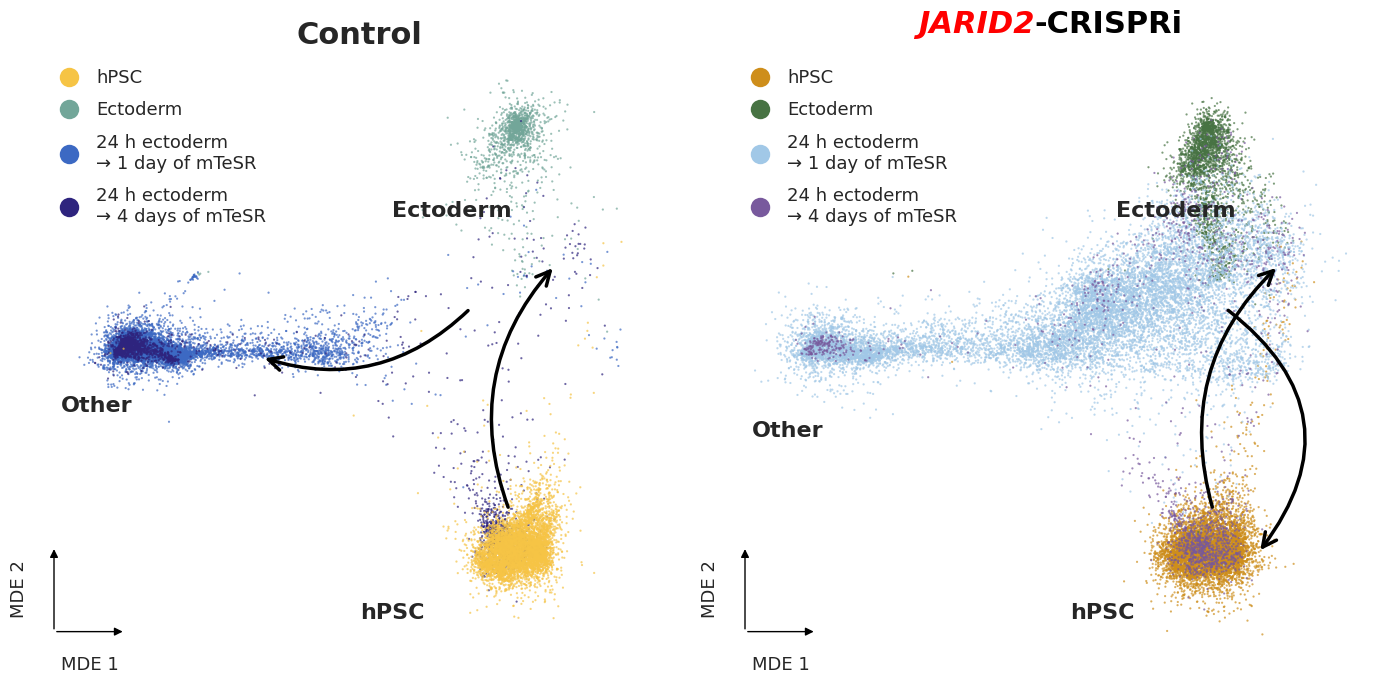

In [25]:
# Keep color_lut for the JARID2-only plot (cell below)
color_lut = { 
    'Ctrl-hPSC.p1' : '#f6c445',
    'JARID2-hPSC'  : '#CE8E1B',
    'Ctrl-E.p6' : '#72a699',
    'JARID2-E'  : '#477343',
    'Ctrl-ET.p1': "#3c69c3",
    'JARID2-ET' : '#a1c8e7',
    'H1-E4T.3'  : '#2e247e', 
    'JARID2-E4T': '#78599d'
}

import seaborn as sns, matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import TextArea, HPacker, AnchoredOffsetbox

# =================== SWITCHES ===================
DRAW_BENT_ARROWS = True   # Toggle trajectory arrows & cluster labels
# ================================================

# Legend label mapping (shared labels across both panels)
legend_lut = { 
    'Ctrl-hPSC.p1' : 'hPSC',
    'JARID2-hPSC'  : 'hPSC',
    'Ctrl-E.p6'    : 'Ectoderm',
    'JARID2-E'     : 'Ectoderm',
    'Ctrl-ET.p1'   : '24 h ectoderm\n\u2192 1 day of mTeSR',
    'JARID2-ET'    : '24 h ectoderm\n\u2192 1 day of mTeSR',
    'H1-E4T.3'    : '24 h ectoderm\n\u2192 4 days of mTeSR',
    'JARID2-E4T'  : '24 h ectoderm\n\u2192 4 days of mTeSR'
}

# Each panel keeps its original colors
ctrl_cond_colors = {
    'hPSC': '#f6c445',
    'Ectoderm': '#72a699',
    '24 h ectoderm\n\u2192 1 day of mTeSR': '#3c69c3',
    '24 h ectoderm\n\u2192 4 days of mTeSR': '#2e247e'
}

jarid2_cond_colors = {
    'hPSC': '#CE8E1B',
    'Ectoderm': '#477343',
    '24 h ectoderm\n\u2192 1 day of mTeSR': '#a1c8e7',
    '24 h ectoderm\n\u2192 4 days of mTeSR': '#78599d'
}

ctrl_samples = ['Ctrl-hPSC.p1', 'Ctrl-E.p6', 'Ctrl-ET.p1', 'H1-E4T.3']
jarid2_samples = ['JARID2-hPSC', 'JARID2-E', 'JARID2-ET', 'JARID2-E4T']
cond_order = list(ctrl_cond_colors.keys())

# ---- Bent arrow configs (axes fraction) — adjust positions as needed ----
# Each arrow: (tail_xy, head_xy, arc_rad)

# Left panel (Control):  hPSC -> Ectoderm,  Ectoderm -> Other
# (arrows shifted right by +0.25 panel width)
ctrl_bent_arrows = [
    ((0.73, 0.25), (0.80, 0.65), -0.3),   # hPSC -> Ectoderm
    ((0.67, 0.58), (0.35, 0.50), -0.3),   # Ectoderm -> Other
]

# Right panel (JARID2):  hPSC -> Ectoderm,  Ectoderm -> hPSC (mid bends left)
# (arrows shifted right by +0.25 panel width)
jarid2_bent_arrows = [
    ((0.75, 0.25), (0.85, 0.65), -0.3),   # hPSC -> Ectoderm
    ((0.77, 0.58), (0.82, 0.18), -0.5),   # Ectoderm -> hPSC (reversion)
]

# Cluster labels per panel: (text, xy_axes_fraction, ha)
# "Other" shifted down; "Ectoderm" shifted upper-left
ctrl_cluster_labels = [
    ('hPSC',      (0.55, 0.08), 'center'),
    ('Ectoderm',  (0.55, 0.74), 'left'),
    ('Other',     (0.04, 0.42), 'left'),
]
jarid2_cluster_labels = [
    ('hPSC',      (0.58, 0.08), 'center'),
    ('Ectoderm',  (0.60, 0.74), 'left'),
    ('Other',     (0.04, 0.38), 'left'),
]

# Prepare data
data = pd.DataFrame(adata2.obsm['X_mde'], columns=['MDE_1', 'MDE_2'])
data['Sample'] = adata2.obs['sample'].astype(str).tolist()
data['Condition'] = data['Sample'].map(legend_lut)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

# Remove spines from both panels
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel(''); ax.set_ylabel('')

# --- Left panel: Control ---
# Draw order: hPSC last (on top) by giving it the highest sort value
data_ctrl = data[data['Sample'].isin(ctrl_samples)].copy()
ctrl_draw_order = ['Ectoderm',
                   '24 h ectoderm\n\u2192 1 day of mTeSR',
                   '24 h ectoderm\n\u2192 4 days of mTeSR',
                   'hPSC']   # hPSC drawn last = on top
data_ctrl['_order'] = data_ctrl['Condition'].map({c: i for i, c in enumerate(ctrl_draw_order)})
data_ctrl = data_ctrl.sort_values('_order')

sns.scatterplot(data=data_ctrl, x='MDE_1', y='MDE_2', hue='Condition',
                palette=ctrl_cond_colors, s=2, alpha=0.7, edgecolor=None,
                hue_order=cond_order, legend=False, ax=ax1, rasterized=True)
ax1.set_title('Control', fontsize=22, fontweight='bold')

ctrl_handles = [Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=ctrl_cond_colors[c],
                       markeredgecolor='none',
                       markersize=14, alpha=1.0)
                for c in cond_order]
ax1.legend(handles=ctrl_handles, labels=cond_order,
           loc='upper left', frameon=False, fontsize=13,
           handletextpad=0.5, labelspacing=0.8)

# --- Right panel: JARID2-CRISPRi ---
data_jarid2 = data[data['Sample'].isin(jarid2_samples)].copy()
data_jarid2['_order'] = data_jarid2['Condition'].map({c: i for i, c in enumerate(cond_order)})
data_jarid2 = data_jarid2.sort_values('_order')

sns.scatterplot(data=data_jarid2, x='MDE_1', y='MDE_2', hue='Condition',
                palette=jarid2_cond_colors, s=2, alpha=0.7, edgecolor=None,
                hue_order=cond_order, legend=False, ax=ax2, rasterized=True)

t1 = TextArea("JARID2", textprops=dict(color="red", fontstyle="italic",
              fontsize=22, fontweight='bold'))
t2 = TextArea("-CRISPRi", textprops=dict(color="black",
              fontsize=22, fontweight='bold'))
title_box = HPacker(children=[t1, t2], pad=0, sep=0)
anchored_title = AnchoredOffsetbox(loc='lower center', child=title_box,
                                    pad=0, frameon=False,
                                    bbox_to_anchor=(0.5, 1.01),
                                    bbox_transform=ax2.transAxes)
ax2.add_artist(anchored_title)

jarid2_handles = [Line2D([0], [0], marker='o', color='w',
                         markerfacecolor=jarid2_cond_colors[c],
                         markeredgecolor='none',
                         markersize=14, alpha=1.0)
                  for c in cond_order]
ax2.legend(handles=jarid2_handles, labels=cond_order,
           loc='upper left', frameon=False, fontsize=13,
           handletextpad=0.5, labelspacing=0.8)

# --- Bent trajectory arrows & cluster labels (per panel) ---
if DRAW_BENT_ARROWS:
    for ax, arrows, labels in [(ax1, ctrl_bent_arrows, ctrl_cluster_labels),
                                (ax2, jarid2_bent_arrows, jarid2_cluster_labels)]:
        for (start, end, rad) in arrows:
            ax.annotate('', xy=end, xytext=start,
                        xycoords='axes fraction', textcoords='axes fraction',
                        arrowprops=dict(arrowstyle='->', mutation_scale=25,
                                        lw=2.5, color='black',
                                        connectionstyle=f'arc3,rad={rad}'))
        for (text, xy, ha) in labels:
            ax.text(xy[0], xy[1], text, transform=ax.transAxes,
                    fontsize=16, fontweight='bold', ha=ha, va='center')

# --- MDE axis indicator (both panels, tails share same origin) ---
for ax in [ax1, ax2]:
    origin = (0.03, 0.05)
    ax.annotate('', xy=(0.14, 0.05), xytext=origin,
                xycoords='axes fraction',
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1.0))
    ax.text(0.085, 0.01, 'MDE 1', transform=ax.transAxes,
            ha='center', va='top', fontsize=13)
    ax.annotate('', xy=(0.03, 0.19), xytext=origin,
                xycoords='axes fraction',
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1.0))
    ax.text(-0.01, 0.12, 'MDE 2', transform=ax.transAxes,
            ha='right', va='center', fontsize=13, rotation=90)

plt.tight_layout()
plt.savefig("Figure2.Samples.MDEmap.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Violin plots -- no scatter points (size=0)

In [7]:
# Figure 1 color setup
H1_color_lut = {
    'H1-hPSC.p6' : '#f6c445',
    'H1-0.5E'  : '#47aa43',
 
    'H1-0.5ET' : '#72a699',
    'H1-0.5E4T'  : '#65dcee',
    
    'H1-E': '#36753b',
    'H1-ET' : '#3c69c3',
    'H1-E4T.1'  : '#2e247e', 
}

order1=['H1-hPSC.p6', 'H1-0.5E', 'H1-0.5ET', 'H1-0.5E4T', 'H1-E', 'H1-ET', 'H1-E4T.1']

adata1.uns['sample_colors'] = [H1_color_lut[cat] for cat in adata1.obs['sample'].cat.categories]

/tmp/ipykernel_16940/1360790463.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df1, x='Sample', y=gene,


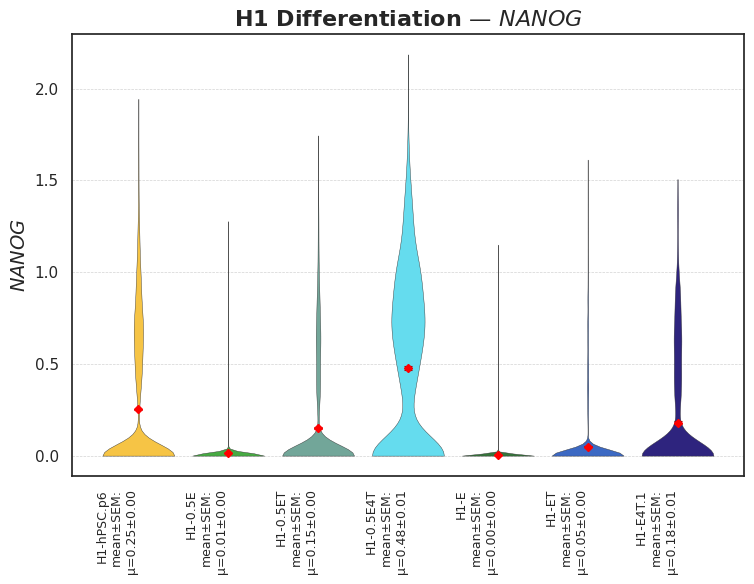

In [36]:
# =================== CONFIG ===================
gene = 'NANOG'
SHOW_NONZERO_MEAN_FIG1 = False   # Show non-zero mean (open red diamond)
# ===============================================

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sample_order_1 = ['H1-hPSC.p6', 'H1-0.5E', 'H1-0.5ET', 'H1-0.5E4T',
                   'H1-E', 'H1-ET', 'H1-E4T.1']

WIDTH_PER_VIOLIN = 1.1
fig_w = WIDTH_PER_VIOLIN * len(sample_order_1)

all_df1 = pd.DataFrame({
    gene: np.asarray(adata1[:, gene].X.toarray()).flatten(),
    'Sample': adata1.obs['sample'].values,
})

fig, ax = plt.subplots(figsize=(fig_w, 6))

sns.violinplot(data=all_df1, x='Sample', y=gene,
               order=sample_order_1, palette=H1_color_lut,
               ax=ax, linewidth=0.3, inner=None, density_norm='count',
               saturation=1, cut=0)

# Horizontal grid lines
ax.yaxis.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
ax.set_axisbelow(True)

# Mean ± SEM diamonds
for i, sample in enumerate(sample_order_1):
    vals = all_df1.loc[all_df1['Sample'] == sample, gene]
    ax.errorbar(i, vals.mean(), yerr=vals.sem(),
                fmt='D', color='red', markersize=4,
                ecolor='darkred', elinewidth=1, capsize=3, capthick=0.8, zorder=5)
    if SHOW_NONZERO_MEAN_FIG1:
        nz = vals[vals > 0]
        if len(nz) > 0:
            ax.errorbar(i, nz.mean(), yerr=nz.sem(),
                        fmt='D', markerfacecolor='none', markeredgecolor='red',
                        markersize=4, ecolor='red', elinewidth=1,
                        capsize=3, capthick=0.8, zorder=5)

# Figure title (gene in italic)
ax.set_title(f'H1 Differentiation \u2014 $\\it{{{gene}}}$', fontsize=16, fontweight='bold')

# X-axis labels: sample name + mean±SEM
tick_labels = []
for s in sample_order_1:
    vals = all_df1.loc[all_df1['Sample'] == s, gene]
    tick_labels.append(
        f"{s}\n"
        f"mean\u00b1SEM:\n"
        f"\u03bc={vals.mean():.2f}\u00b1{vals.sem():.2f}"
    )
ax.set_xticks(range(len(sample_order_1)))
ax.set_xticklabels(tick_labels, rotation=90, ha='right', fontsize=9)

ax.set_xlabel('')
ax.set_ylabel(f'$\\it{{{gene}}}$', fontsize=14)

plt.tight_layout()
plt.savefig(f'Figure1.{gene}.violin.pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_16940/1618254211.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


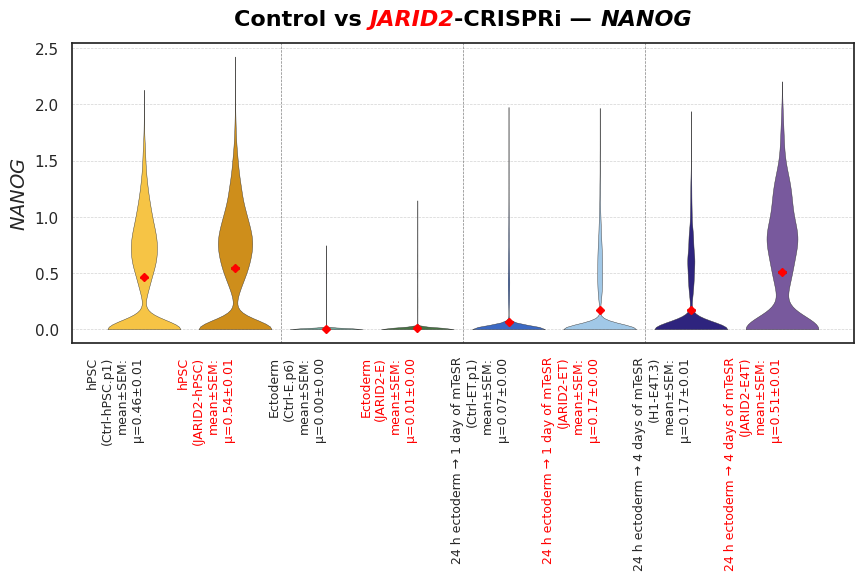

In [37]:
# =================== CONFIG ===================
gene = 'NANOG'
SHOW_NONZERO_MEAN = False   # Show non-zero mean (open red diamond) to combat dropouts
# ===============================================

import numpy as np
from matplotlib.transforms import blended_transform_factory
from matplotlib.offsetbox import TextArea, HPacker, AnchoredOffsetbox

# Interleaved order: Ctrl and JARID2 side by side for each condition
sample_order = ['Ctrl-hPSC.p1', 'JARID2-hPSC',
                'Ctrl-E.p6', 'JARID2-E',
                'Ctrl-ET.p1', 'JARID2-ET',
                'H1-E4T.3', 'JARID2-E4T']

jarid2_set = set(jarid2_samples)

WIDTH_PER_VIOLIN = 1.1
fig_w = WIDTH_PER_VIOLIN * len(sample_order)

# Per-sample colors from condition palettes
sample_palette = {}
for s in ctrl_samples:
    sample_palette[s] = ctrl_cond_colors[legend_lut[s]]
for s in jarid2_samples:
    sample_palette[s] = jarid2_cond_colors[legend_lut[s]]

# Prepare data
all_df = pd.DataFrame({
    gene: np.asarray(adata2[:, gene].X.toarray()).flatten(),
    'Sample': adata2.obs['sample'].values,
})

fig, ax = plt.subplots(figsize=(fig_w, 6))

sns.violinplot(data=all_df, x='Sample', y=gene,
               order=sample_order, palette=sample_palette,
               ax=ax, linewidth=0.3, inner=None, density_norm='count',
               saturation=1, cut=0)

# Horizontal grid lines (shallow gray dashed, behind violins)
ax.yaxis.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
ax.set_axisbelow(True)

# Mean ± SEM: red diamond at mean, error bars extending from mean
for i, sample in enumerate(sample_order):
    vals = all_df.loc[all_df['Sample'] == sample, gene]
    ax.errorbar(i, vals.mean(), yerr=vals.sem(),
                fmt='D', color='red', markersize=4,
                ecolor='darkred', elinewidth=1, capsize=3, capthick=0.8, zorder=5)
    if SHOW_NONZERO_MEAN:
        nz = vals[vals > 0]
        if len(nz) > 0:
            ax.errorbar(i, nz.mean(), yerr=nz.sem(),
                        fmt='D', markerfacecolor='none', markeredgecolor='red',
                        markersize=4, ecolor='red', elinewidth=1,
                        capsize=3, capthick=0.8, zorder=5)

# Vertical separators between condition pairs
for sep_x in [1.5, 3.5, 5.5]:
    ax.axvline(sep_x, color='gray', linewidth=0.5, linestyle='--')

# Figure title: "Control vs JARID2-CRISPRi — NANOG" (gene in italic)
t_ctrl = TextArea("Control vs ", textprops=dict(color="black", fontsize=16, fontweight='bold'))
t_j1 = TextArea("JARID2", textprops=dict(color="red", fontstyle="italic",
                fontsize=16, fontweight='bold'))
t_j2 = TextArea("-CRISPRi \u2014 ", textprops=dict(color="black", fontsize=16, fontweight='bold'))
t_gene = TextArea(f"{gene}", textprops=dict(color="black", fontsize=16,
                  fontweight='bold', fontstyle='italic'))
title_box = HPacker(children=[t_ctrl, t_j1, t_j2, t_gene], pad=0, sep=0)
anchored_title = AnchoredOffsetbox(loc='lower center', child=title_box,
                                    pad=0, frameon=False,
                                    bbox_to_anchor=(0.5, 1.02),
                                    bbox_transform=ax.transAxes)
ax.add_artist(anchored_title)

# X-axis labels with condition + sample + mean±SEM
tick_labels = []
for s in sample_order:
    vals = all_df.loc[all_df['Sample'] == s, gene]
    cond = legend_lut[s].replace('\n', ' ')
    tick_labels.append(
        f"{cond}\n({s})\n"
        f"mean\u00b1SEM:\n"
        f"\u03bc={vals.mean():.2f}\u00b1{vals.sem():.2f}"
    )
ax.set_xticks(range(len(sample_order)))
ax.set_xticklabels(tick_labels, rotation=90, ha='right', fontsize=9)

# Color JARID2 tick labels red
for i, label in enumerate(ax.get_xticklabels()):
    if sample_order[i] in jarid2_set:
        label.set_color('red')

ax.set_xlabel('')
ax.set_ylabel(f'$\\it{{{gene}}}$', fontsize=14)

plt.tight_layout()
plt.savefig(f'Figure2.{gene}.violin.pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_16940/3036059320.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df1, x='Sample', y=gene,


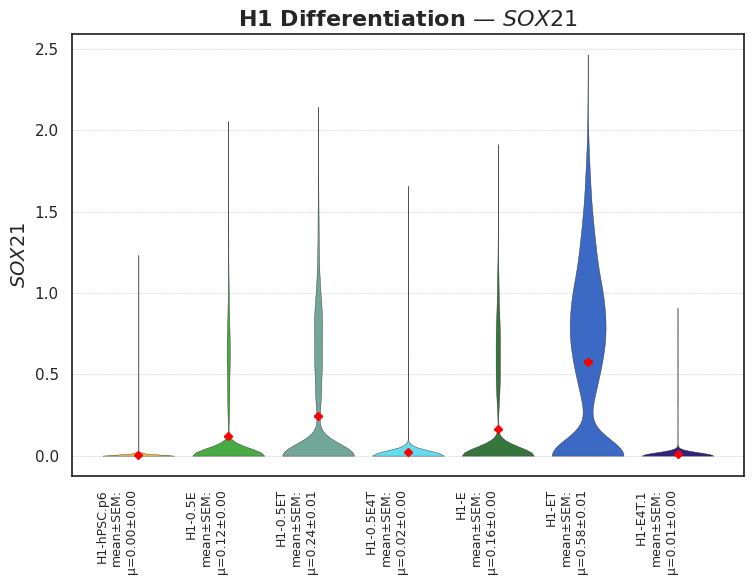

In [38]:
# =================== CONFIG ===================
gene = 'SOX21'
SHOW_NONZERO_MEAN_FIG1 = False   # Show non-zero mean (open red diamond)
# ===============================================

sample_order_1 = ['H1-hPSC.p6', 'H1-0.5E', 'H1-0.5ET', 'H1-0.5E4T',
                   'H1-E', 'H1-ET', 'H1-E4T.1']

WIDTH_PER_VIOLIN = 1.1
fig_w = WIDTH_PER_VIOLIN * len(sample_order_1)

all_df1 = pd.DataFrame({
    gene: np.asarray(adata1[:, gene].X.toarray()).flatten(),
    'Sample': adata1.obs['sample'].values,
})

fig, ax = plt.subplots(figsize=(fig_w, 6))

sns.violinplot(data=all_df1, x='Sample', y=gene,
               order=sample_order_1, palette=H1_color_lut,
               ax=ax, linewidth=0.3, inner=None, density_norm='count',
               saturation=1, cut=0)

# Horizontal grid lines
ax.yaxis.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
ax.set_axisbelow(True)

# Mean ± SEM diamonds
for i, sample in enumerate(sample_order_1):
    vals = all_df1.loc[all_df1['Sample'] == sample, gene]
    ax.errorbar(i, vals.mean(), yerr=vals.sem(),
                fmt='D', color='red', markersize=4,
                ecolor='darkred', elinewidth=1, capsize=3, capthick=0.8, zorder=5)
    if SHOW_NONZERO_MEAN_FIG1:
        nz = vals[vals > 0]
        if len(nz) > 0:
            ax.errorbar(i, nz.mean(), yerr=nz.sem(),
                        fmt='D', markerfacecolor='none', markeredgecolor='red',
                        markersize=4, ecolor='red', elinewidth=1,
                        capsize=3, capthick=0.8, zorder=5)

# Figure title (gene in italic)
ax.set_title(f'H1 Differentiation \u2014 $\\it{{{gene}}}$', fontsize=16, fontweight='bold')

# X-axis labels: sample name + mean±SEM
tick_labels = []
for s in sample_order_1:
    vals = all_df1.loc[all_df1['Sample'] == s, gene]
    tick_labels.append(
        f"{s}\n"
        f"mean\u00b1SEM:\n"
        f"\u03bc={vals.mean():.2f}\u00b1{vals.sem():.2f}"
    )
ax.set_xticks(range(len(sample_order_1)))
ax.set_xticklabels(tick_labels, rotation=90, ha='right', fontsize=9)

ax.set_xlabel('')
ax.set_ylabel(f'$\\it{{{gene}}}$', fontsize=14)

plt.tight_layout()
plt.savefig(f'Figure1.{gene}.violin.pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_16940/2957264310.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_df, x='Sample', y=gene,


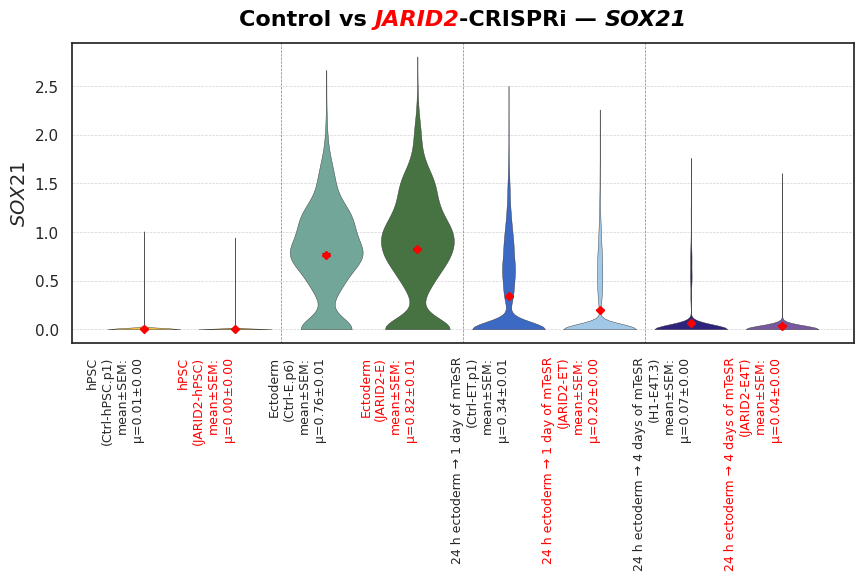

In [39]:
# =================== CONFIG ===================
gene = 'SOX21'
SHOW_NONZERO_MEAN = False   # Show non-zero mean (open red diamond) to combat dropouts
# ===============================================

# Interleaved order: Ctrl and JARID2 side by side for each condition
sample_order = ['Ctrl-hPSC.p1', 'JARID2-hPSC',
                'Ctrl-E.p6', 'JARID2-E',
                'Ctrl-ET.p1', 'JARID2-ET',
                'H1-E4T.3', 'JARID2-E4T']

jarid2_set = set(jarid2_samples)

WIDTH_PER_VIOLIN = 1.1
fig_w = WIDTH_PER_VIOLIN * len(sample_order)

# Per-sample colors from condition palettes
sample_palette = {}
for s in ctrl_samples:
    sample_palette[s] = ctrl_cond_colors[legend_lut[s]]
for s in jarid2_samples:
    sample_palette[s] = jarid2_cond_colors[legend_lut[s]]

# Prepare data
all_df = pd.DataFrame({
    gene: np.asarray(adata2[:, gene].X.toarray()).flatten(),
    'Sample': adata2.obs['sample'].values,
})

fig, ax = plt.subplots(figsize=(fig_w, 6))

sns.violinplot(data=all_df, x='Sample', y=gene,
               order=sample_order, palette=sample_palette,
               ax=ax, linewidth=0.3, inner=None, density_norm='count',
               saturation=1, cut=0)

# Horizontal grid lines
ax.yaxis.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
ax.set_axisbelow(True)

# Mean ± SEM: red diamond at mean, error bars extending from mean
for i, sample in enumerate(sample_order):
    vals = all_df.loc[all_df['Sample'] == sample, gene]
    ax.errorbar(i, vals.mean(), yerr=vals.sem(),
                fmt='D', color='red', markersize=4,
                ecolor='darkred', elinewidth=1, capsize=3, capthick=0.8, zorder=5)
    if SHOW_NONZERO_MEAN:
        nz = vals[vals > 0]
        if len(nz) > 0:
            ax.errorbar(i, nz.mean(), yerr=nz.sem(),
                        fmt='D', markerfacecolor='none', markeredgecolor='red',
                        markersize=4, ecolor='red', elinewidth=1,
                        capsize=3, capthick=0.8, zorder=5)

# Vertical separators between condition pairs
for sep_x in [1.5, 3.5, 5.5]:
    ax.axvline(sep_x, color='gray', linewidth=0.5, linestyle='--')

# Figure title: "Control vs JARID2-CRISPRi — SOX21" (gene in italic)
t_ctrl = TextArea("Control vs ", textprops=dict(color="black", fontsize=16, fontweight='bold'))
t_j1 = TextArea("JARID2", textprops=dict(color="red", fontstyle="italic",
                fontsize=16, fontweight='bold'))
t_j2 = TextArea("-CRISPRi \u2014 ", textprops=dict(color="black", fontsize=16, fontweight='bold'))
t_gene = TextArea(f"{gene}", textprops=dict(color="black", fontsize=16,
                  fontweight='bold', fontstyle='italic'))
title_box = HPacker(children=[t_ctrl, t_j1, t_j2, t_gene], pad=0, sep=0)
anchored_title = AnchoredOffsetbox(loc='lower center', child=title_box,
                                    pad=0, frameon=False,
                                    bbox_to_anchor=(0.5, 1.02),
                                    bbox_transform=ax.transAxes)
ax.add_artist(anchored_title)

# X-axis labels with condition + sample + mean±SEM
tick_labels = []
for s in sample_order:
    vals = all_df.loc[all_df['Sample'] == s, gene]
    cond = legend_lut[s].replace('\n', ' ')
    tick_labels.append(
        f"{cond}\n({s})\n"
        f"mean\u00b1SEM:\n"
        f"\u03bc={vals.mean():.2f}\u00b1{vals.sem():.2f}"
    )
ax.set_xticks(range(len(sample_order)))
ax.set_xticklabels(tick_labels, rotation=90, ha='right', fontsize=9)

# Color JARID2 tick labels red
for i, label in enumerate(ax.get_xticklabels()):
    if sample_order[i] in jarid2_set:
        label.set_color('red')

ax.set_xlabel('')
ax.set_ylabel(f'$\\it{{{gene}}}$', fontsize=14)

plt.tight_layout()
plt.savefig(f'Figure2.{gene}.violin.pdf', dpi=300, bbox_inches='tight')
plt.show()

## SOX21 MDE feature plots

Saved: Figure1.SOX21.MDEmap.pdf


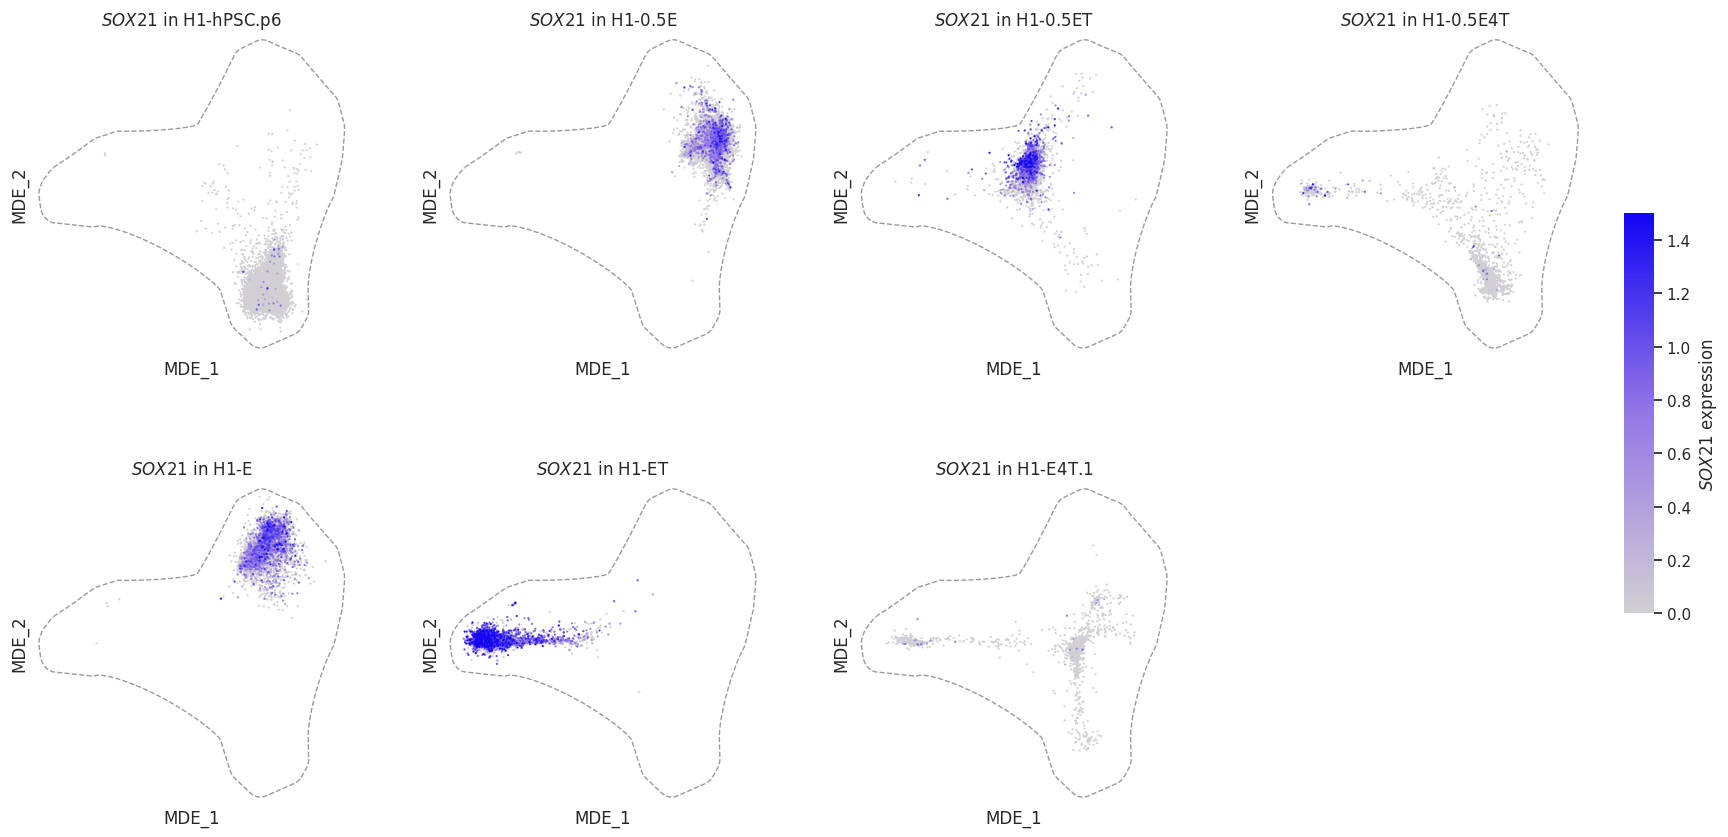

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter1d
from shapely.geometry import MultiLineString, Polygon
from shapely.ops import unary_union, polygonize

# =================== CONFIG ===================
gene = 'SOX21'
SAVE_FILE = f'Figure1.{gene}.MDEmap.pdf'
ALPHA = 2.0          # concavity: higher = tighter fit; lower = more convex
BUFFER = 0.15        # margin around the hull (larger = more padding)
SMOOTH_RES = 128     # buffer resolution: segments per quarter-circle (higher = smoother)
GAUSS_SIGMA = 3      # Gaussian smoothing sigma on hull boundary coords
SUBSAMPLE = 5000     # max points for hull computation (speed)
vmin, vmax = 0, 1.5  # color range
# ===============================================

def concave_hull(points, alpha=2.0, buffer_dist=0.15, resolution=128):
    """Concave hull (alpha shape) with smooth buffered margin."""
    pts = np.array(points)
    tri = Delaunay(pts)
    edges = set()
    for simplex in tri.simplices:
        pa, pb, pc = pts[simplex]
        a = np.linalg.norm(pa - pb)
        b = np.linalg.norm(pb - pc)
        c = np.linalg.norm(pc - pa)
        s = (a + b + c) / 2.0
        area_sq = s * (s - a) * (s - b) * (s - c)
        if area_sq > 0:
            circum_r = (a * b * c) / (4.0 * np.sqrt(area_sq))
        else:
            continue
        if circum_r < 1.0 / alpha:
            for i, j in [(0, 1), (1, 2), (2, 0)]:
                edge = tuple(sorted([simplex[i], simplex[j]]))
                edges.add(edge)
    lines = [((pts[i][0], pts[i][1]), (pts[j][0], pts[j][1])) for i, j in edges]
    m = MultiLineString(lines)
    polys = list(polygonize(m))
    if not polys:
        return None
    return unary_union(polys).buffer(buffer_dist, resolution=resolution)

def smooth_hull_coords(hull, sigma=3):
    """Extract hull boundary coords and apply Gaussian smoothing for extra smoothness."""
    if hull is None:
        return []
    polygons = [hull] if hull.geom_type == 'Polygon' else list(hull.geoms)
    result = []
    for poly in polygons:
        x, y = np.array(poly.exterior.coords.xy)
        x_smooth = gaussian_filter1d(x, sigma=sigma, mode='wrap')
        y_smooth = gaussian_filter1d(y, sigma=sigma, mode='wrap')
        result.append((x_smooth, y_smooth))
    return result

def plot_hull(ax, hull_coords_list, **kwargs):
    """Draw pre-smoothed hull boundaries on axes."""
    defaults = dict(linestyle='--', color='gray', linewidth=1, alpha=0.8)
    defaults.update(kwargs)
    for (x, y) in hull_coords_list:
        ax.plot(x, y, **defaults)

def hull_bounds(hull_coords_list, pad=0.05):
    """Get bounding box of hull coords with extra padding."""
    all_x = np.concatenate([x for x, y in hull_coords_list])
    all_y = np.concatenate([y for x, y in hull_coords_list])
    return (all_x.min() - pad, all_x.max() + pad,
            all_y.min() - pad, all_y.max() + pad)

# --- Compute concave hull of ALL Figure 1 points ---
all_pts = adata1.obsm['X_mde']
if len(all_pts) > SUBSAMPLE:
    idx = np.random.default_rng(42).choice(len(all_pts), SUBSAMPLE, replace=False)
    hull_pts = all_pts[idx]
else:
    hull_pts = all_pts
hull1_raw = concave_hull(hull_pts, alpha=ALPHA, buffer_dist=BUFFER, resolution=SMOOTH_RES)
hull1_coords = smooth_hull_coords(hull1_raw, sigma=GAUSS_SIGMA)

# Axis limits from hull extent (so contour is never clipped)
xlo, xhi, ylo, yhi = hull_bounds(hull1_coords, pad=0.05)

# --- Plot ---
sample_list = ['H1-hPSC.p6', 'H1-0.5E', 'H1-0.5ET', 'H1-0.5E4T', 'H1-E', 'H1-ET', 'H1-E4T.1']
ncols = 4
nrows = (len(sample_list) + ncols - 1) // ncols

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
mycmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#d1cfd4", "#9577e5", "#1206f5"])

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
axes = axes.flatten()
sns.set_theme(style="white")

for i, sample_name in enumerate(sample_list):
    adata_sub = adata1[adata1.obs['sample'] == sample_name].copy()
    data1 = pd.DataFrame(adata_sub.obsm['X_mde'], columns=['MDE_1', 'MDE_2'])
    data1[gene] = adata_sub[:, gene].X.toarray().flatten()
    data1 = data1.sort_values(gene).copy()

    ax = axes[i]

    # Hide frame
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Draw smoothed concave hull contour (background)
    plot_hull(ax, hull1_coords)

    scatter = sns.scatterplot(
        data=data1, x='MDE_1', y='MDE_2', hue=gene,
        palette=mycmap, s=2, alpha=1.00, edgecolor=None,
        hue_norm=(vmin, vmax), legend=False, ax=ax
    )
    mappable = scatter.collections[0]
    mappable.set_cmap(mycmap)
    mappable.set_norm(norm)

    ax.set_title(f"$\\it{{{gene}}}$ in {sample_name}")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(xlo, xhi); ax.set_ylim(ylo, yhi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.outline.set_visible(False)
cbar.set_label(f"$\\it{{{gene}}}$ expression")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig(SAVE_FILE, dpi=300, bbox_inches='tight')
print(f"Saved: {SAVE_FILE}")
plt.show()

Saved: Figure2.SOX21.MDEmap.pdf


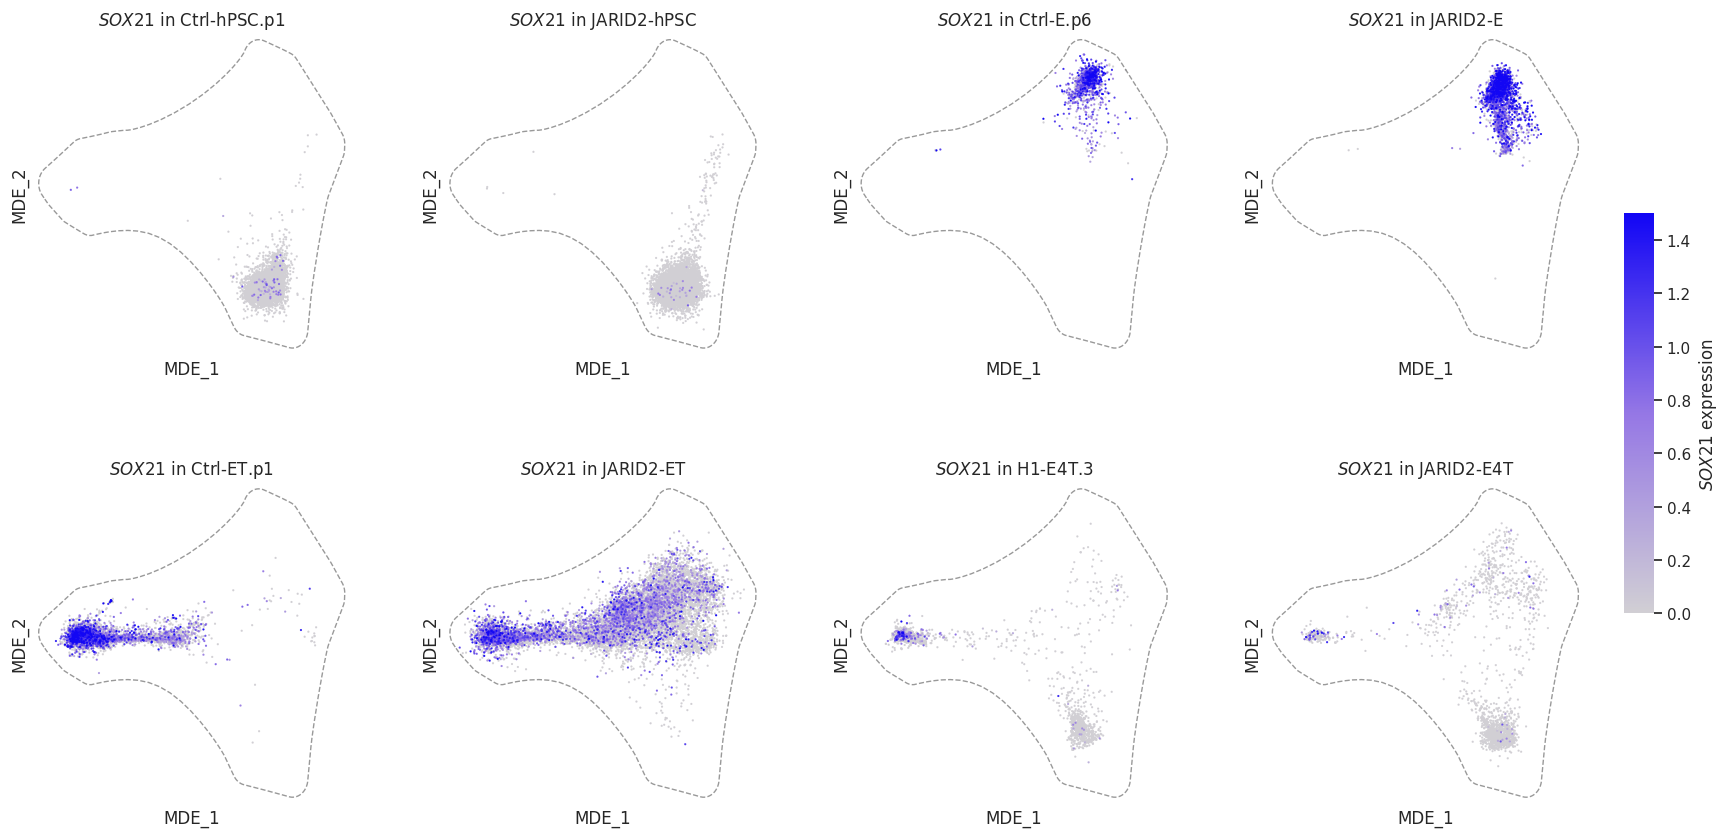

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

# =================== CONFIG ===================
gene = 'SOX21'
SAVE_FILE = f'Figure2.{gene}.MDEmap.pdf'
ALPHA = 2.0          # concavity: higher = tighter fit; lower = more convex
BUFFER = 0.15        # margin around the hull (larger = more padding)
SMOOTH_RES = 128     # buffer resolution: segments per quarter-circle
GAUSS_SIGMA = 3      # Gaussian smoothing sigma on hull boundary coords
SUBSAMPLE = 5000     # max points for hull computation (speed)
vmin, vmax = 0, 1.5  # color range
# ===============================================

# --- Compute concave hull of ALL Figure 2 points ---
all_pts = adata2.obsm['X_mde']
if len(all_pts) > SUBSAMPLE:
    idx = np.random.default_rng(42).choice(len(all_pts), SUBSAMPLE, replace=False)
    hull_pts = all_pts[idx]
else:
    hull_pts = all_pts
hull2_raw = concave_hull(hull_pts, alpha=ALPHA, buffer_dist=BUFFER, resolution=SMOOTH_RES)
hull2_coords = smooth_hull_coords(hull2_raw, sigma=GAUSS_SIGMA)

# Axis limits from hull extent (so contour is never clipped)
xlo, xhi, ylo, yhi = hull_bounds(hull2_coords, pad=0.05)

# --- Plot ---
sample_list = ['Ctrl-hPSC.p1', 'JARID2-hPSC', 'Ctrl-E.p6', 'JARID2-E',
               'Ctrl-ET.p1', 'JARID2-ET', 'H1-E4T.3', 'JARID2-E4T']
ncols = 4
nrows = (len(sample_list) + ncols - 1) // ncols

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
mycmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#d1cfd4", "#9577e5", "#1206f5"])

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
axes = axes.flatten()
sns.set_theme(style="white")

for i, sample_name in enumerate(sample_list):
    adata_sub = adata2[adata2.obs['sample'] == sample_name].copy()
    data1 = pd.DataFrame(adata_sub.obsm['X_mde'], columns=['MDE_1', 'MDE_2'])
    data1[gene] = adata_sub[:, gene].X.toarray().flatten()
    data1 = data1.sort_values(gene).copy()

    ax = axes[i]

    # Hide frame
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Draw smoothed concave hull contour (background)
    plot_hull(ax, hull2_coords)

    scatter = sns.scatterplot(
        data=data1, x='MDE_1', y='MDE_2', hue=gene,
        palette=mycmap, s=2, alpha=1.00, edgecolor=None,
        hue_norm=(vmin, vmax), legend=False, ax=ax
    )
    mappable = scatter.collections[0]
    mappable.set_cmap(mycmap)
    mappable.set_norm(norm)

    ax.set_title(f"$\\it{{{gene}}}$ in {sample_name}")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(xlo, xhi); ax.set_ylim(ylo, yhi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.outline.set_visible(False)
cbar.set_label(f"$\\it{{{gene}}}$ expression")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig(SAVE_FILE, dpi=300, bbox_inches='tight')
print(f"Saved: {SAVE_FILE}")
plt.show()

Saved: Figure1.NANOG.MDEmap.pdf


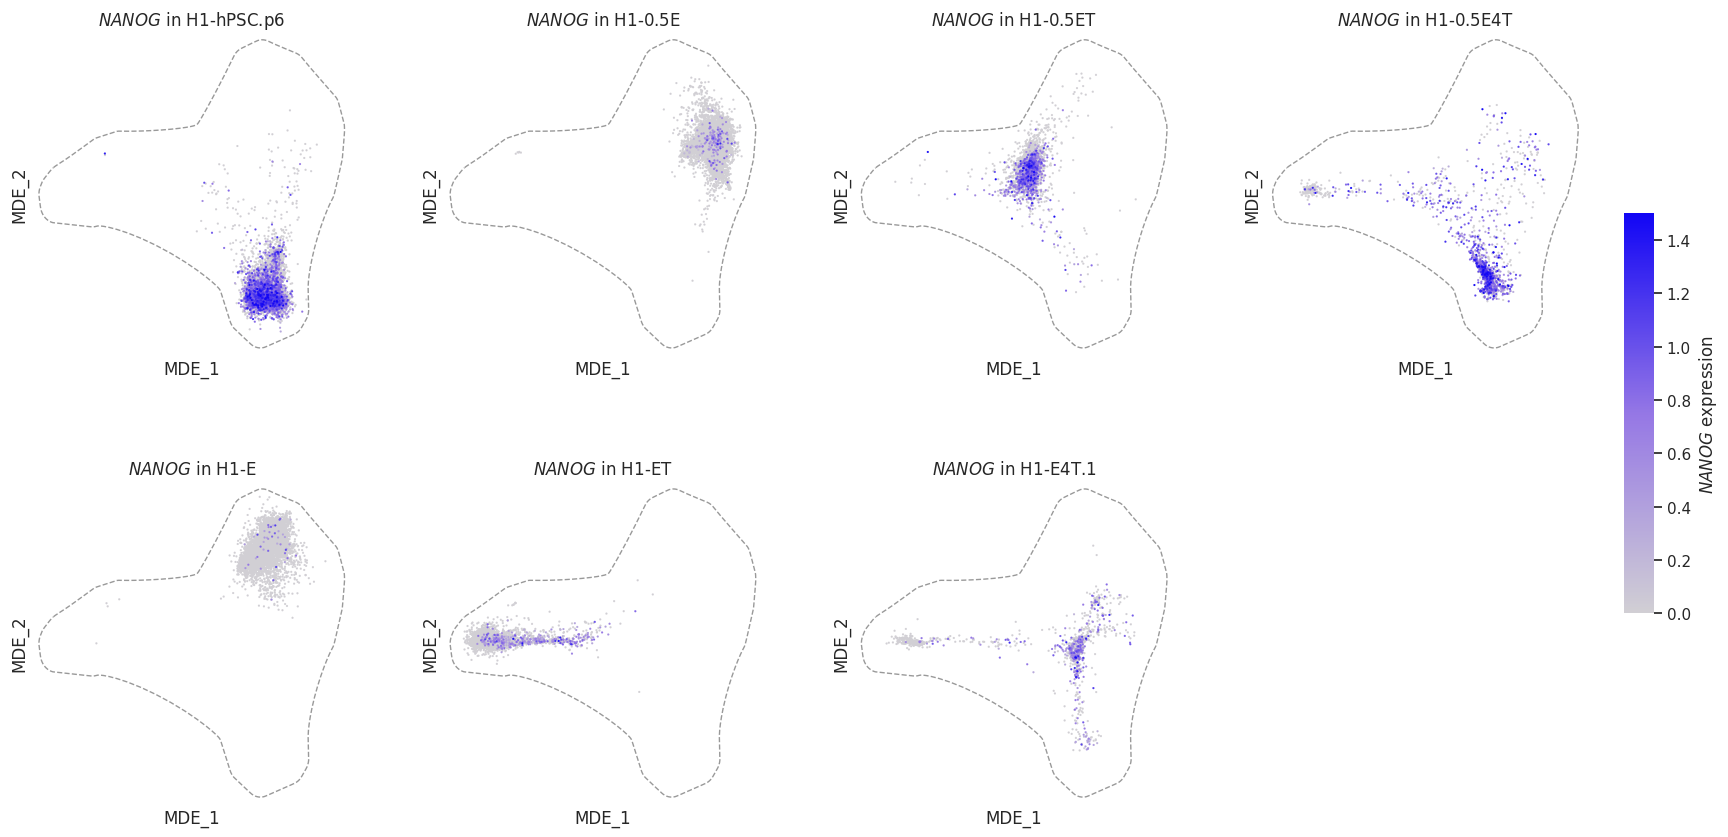

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter1d
from shapely.geometry import MultiLineString, Polygon
from shapely.ops import unary_union, polygonize

# =================== CONFIG ===================
gene = 'NANOG'
SAVE_FILE = f'Figure1.{gene}.MDEmap.pdf'
ALPHA = 2.0          # concavity: higher = tighter fit; lower = more convex
BUFFER = 0.15        # margin around the hull (larger = more padding)
SMOOTH_RES = 128     # buffer resolution: segments per quarter-circle (higher = smoother)
GAUSS_SIGMA = 3      # Gaussian smoothing sigma on hull boundary coords
SUBSAMPLE = 5000     # max points for hull computation (speed)
vmin, vmax = 0, 1.5  # color range
# ===============================================

def concave_hull(points, alpha=2.0, buffer_dist=0.15, resolution=128):
    """Concave hull (alpha shape) with smooth buffered margin."""
    pts = np.array(points)
    tri = Delaunay(pts)
    edges = set()
    for simplex in tri.simplices:
        pa, pb, pc = pts[simplex]
        a = np.linalg.norm(pa - pb)
        b = np.linalg.norm(pb - pc)
        c = np.linalg.norm(pc - pa)
        s = (a + b + c) / 2.0
        area_sq = s * (s - a) * (s - b) * (s - c)
        if area_sq > 0:
            circum_r = (a * b * c) / (4.0 * np.sqrt(area_sq))
        else:
            continue
        if circum_r < 1.0 / alpha:
            for i, j in [(0, 1), (1, 2), (2, 0)]:
                edge = tuple(sorted([simplex[i], simplex[j]]))
                edges.add(edge)
    lines = [((pts[i][0], pts[i][1]), (pts[j][0], pts[j][1])) for i, j in edges]
    m = MultiLineString(lines)
    polys = list(polygonize(m))
    if not polys:
        return None
    return unary_union(polys).buffer(buffer_dist, resolution=resolution)

def smooth_hull_coords(hull, sigma=3):
    """Extract hull boundary coords and apply Gaussian smoothing for extra smoothness."""
    if hull is None:
        return []
    polygons = [hull] if hull.geom_type == 'Polygon' else list(hull.geoms)
    result = []
    for poly in polygons:
        x, y = np.array(poly.exterior.coords.xy)
        x_smooth = gaussian_filter1d(x, sigma=sigma, mode='wrap')
        y_smooth = gaussian_filter1d(y, sigma=sigma, mode='wrap')
        result.append((x_smooth, y_smooth))
    return result

def plot_hull(ax, hull_coords_list, **kwargs):
    """Draw pre-smoothed hull boundaries on axes."""
    defaults = dict(linestyle='--', color='gray', linewidth=1, alpha=0.8)
    defaults.update(kwargs)
    for (x, y) in hull_coords_list:
        ax.plot(x, y, **defaults)

def hull_bounds(hull_coords_list, pad=0.05):
    """Get bounding box of hull coords with extra padding."""
    all_x = np.concatenate([x for x, y in hull_coords_list])
    all_y = np.concatenate([y for x, y in hull_coords_list])
    return (all_x.min() - pad, all_x.max() + pad,
            all_y.min() - pad, all_y.max() + pad)

# --- Compute concave hull of ALL Figure 1 points ---
all_pts = adata1.obsm['X_mde']
if len(all_pts) > SUBSAMPLE:
    idx = np.random.default_rng(42).choice(len(all_pts), SUBSAMPLE, replace=False)
    hull_pts = all_pts[idx]
else:
    hull_pts = all_pts
hull1_raw = concave_hull(hull_pts, alpha=ALPHA, buffer_dist=BUFFER, resolution=SMOOTH_RES)
hull1_coords = smooth_hull_coords(hull1_raw, sigma=GAUSS_SIGMA)

# Axis limits from hull extent (so contour is never clipped)
xlo, xhi, ylo, yhi = hull_bounds(hull1_coords, pad=0.05)

# --- Plot ---
sample_list = ['H1-hPSC.p6', 'H1-0.5E', 'H1-0.5ET', 'H1-0.5E4T', 'H1-E', 'H1-ET', 'H1-E4T.1']
ncols = 4
nrows = (len(sample_list) + ncols - 1) // ncols

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
mycmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#d1cfd4", "#9577e5", "#1206f5"])

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
axes = axes.flatten()
sns.set_theme(style="white")

for i, sample_name in enumerate(sample_list):
    adata_sub = adata1[adata1.obs['sample'] == sample_name].copy()
    data1 = pd.DataFrame(adata_sub.obsm['X_mde'], columns=['MDE_1', 'MDE_2'])
    data1[gene] = adata_sub[:, gene].X.toarray().flatten()
    data1 = data1.sort_values(gene).copy()

    ax = axes[i]

    # Hide frame
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Draw smoothed concave hull contour (background)
    plot_hull(ax, hull1_coords)

    scatter = sns.scatterplot(
        data=data1, x='MDE_1', y='MDE_2', hue=gene,
        palette=mycmap, s=2, alpha=1.00, edgecolor=None,
        hue_norm=(vmin, vmax), legend=False, ax=ax
    )
    mappable = scatter.collections[0]
    mappable.set_cmap(mycmap)
    mappable.set_norm(norm)

    ax.set_title(f"$\\it{{{gene}}}$ in {sample_name}")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(xlo, xhi); ax.set_ylim(ylo, yhi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.outline.set_visible(False)
cbar.set_label(f"$\\it{{{gene}}}$ expression")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig(SAVE_FILE, dpi=300, bbox_inches='tight')
print(f"Saved: {SAVE_FILE}")
plt.show()

Saved: Figure2.NANOG.MDEmap.pdf


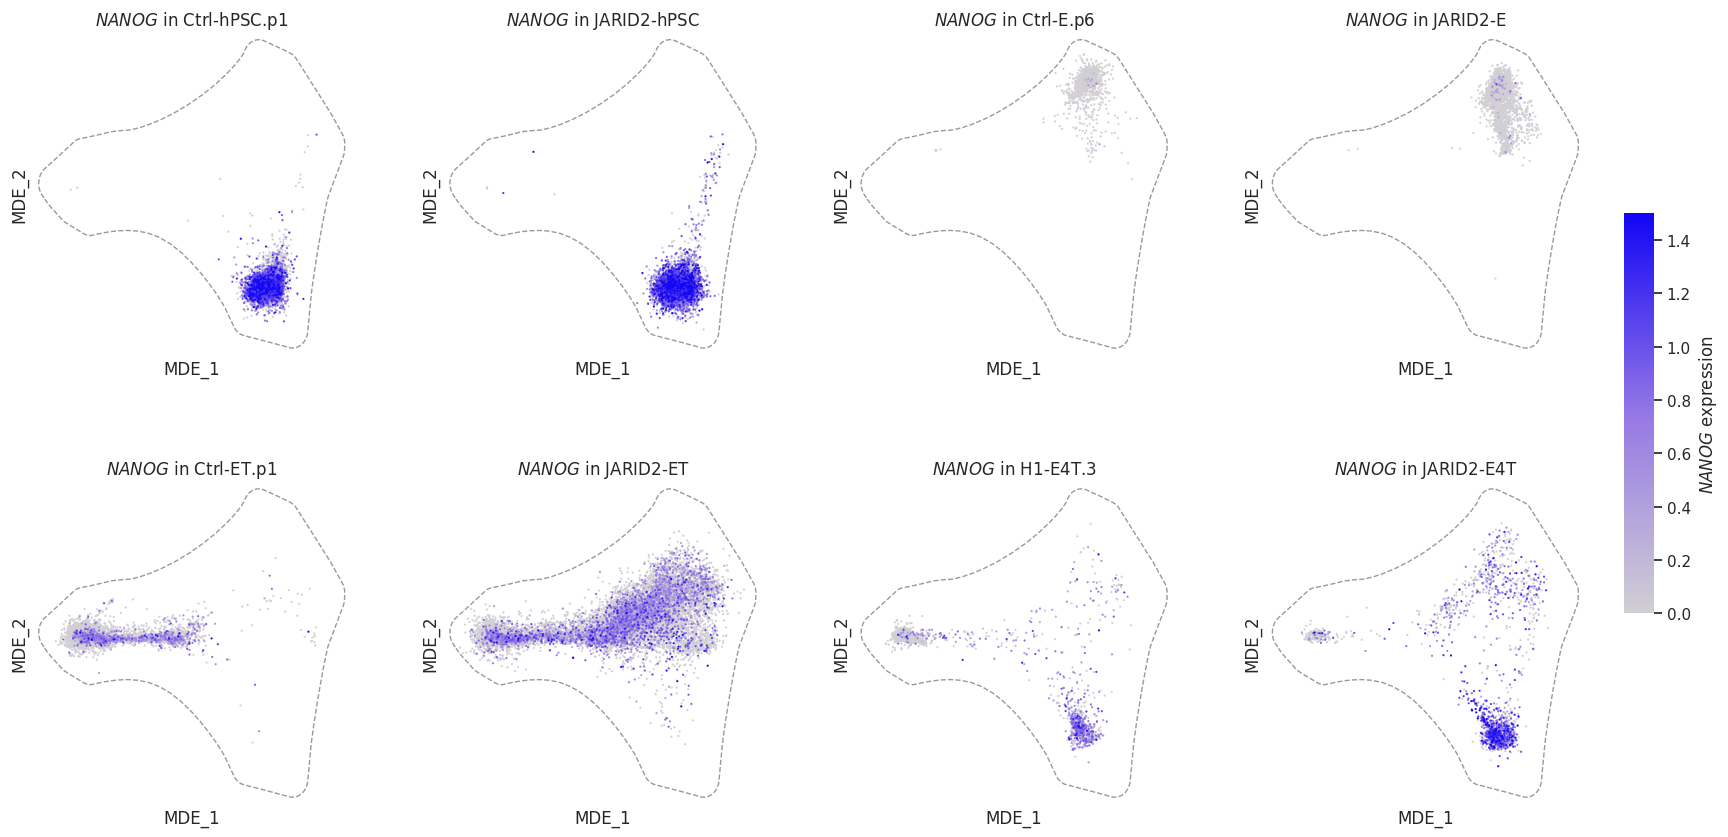

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

# =================== CONFIG ===================
gene = 'NANOG'
SAVE_FILE = f'Figure2.{gene}.MDEmap.pdf'
ALPHA = 2.0          # concavity: higher = tighter fit; lower = more convex
BUFFER = 0.15        # margin around the hull (larger = more padding)
SMOOTH_RES = 128     # buffer resolution: segments per quarter-circle
GAUSS_SIGMA = 3      # Gaussian smoothing sigma on hull boundary coords
SUBSAMPLE = 5000     # max points for hull computation (speed)
vmin, vmax = 0, 1.5  # color range
# ===============================================

# --- Compute concave hull of ALL Figure 2 points ---
all_pts = adata2.obsm['X_mde']
if len(all_pts) > SUBSAMPLE:
    idx = np.random.default_rng(42).choice(len(all_pts), SUBSAMPLE, replace=False)
    hull_pts = all_pts[idx]
else:
    hull_pts = all_pts
hull2_raw = concave_hull(hull_pts, alpha=ALPHA, buffer_dist=BUFFER, resolution=SMOOTH_RES)
hull2_coords = smooth_hull_coords(hull2_raw, sigma=GAUSS_SIGMA)

# Axis limits from hull extent (so contour is never clipped)
xlo, xhi, ylo, yhi = hull_bounds(hull2_coords, pad=0.05)

# --- Plot ---
sample_list = ['Ctrl-hPSC.p1', 'JARID2-hPSC', 'Ctrl-E.p6', 'JARID2-E',
               'Ctrl-ET.p1', 'JARID2-ET', 'H1-E4T.3', 'JARID2-E4T']
ncols = 4
nrows = (len(sample_list) + ncols - 1) // ncols

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
mycmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#d1cfd4", "#9577e5", "#1206f5"])

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
axes = axes.flatten()
sns.set_theme(style="white")

for i, sample_name in enumerate(sample_list):
    adata_sub = adata2[adata2.obs['sample'] == sample_name].copy()
    data1 = pd.DataFrame(adata_sub.obsm['X_mde'], columns=['MDE_1', 'MDE_2'])
    data1[gene] = adata_sub[:, gene].X.toarray().flatten()
    data1 = data1.sort_values(gene).copy()

    ax = axes[i]

    # Hide frame
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Draw smoothed concave hull contour (background)
    plot_hull(ax, hull2_coords)

    scatter = sns.scatterplot(
        data=data1, x='MDE_1', y='MDE_2', hue=gene,
        palette=mycmap, s=2, alpha=1.00, edgecolor=None,
        hue_norm=(vmin, vmax), legend=False, ax=ax
    )
    mappable = scatter.collections[0]
    mappable.set_cmap(mycmap)
    mappable.set_norm(norm)

    ax.set_title(f"$\\it{{{gene}}}$ in {sample_name}")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(xlo, xhi); ax.set_ylim(ylo, yhi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.outline.set_visible(False)
cbar.set_label(f"$\\it{{{gene}}}$ expression")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig(SAVE_FILE, dpi=300, bbox_inches='tight')
print(f"Saved: {SAVE_FILE}")
plt.show()

---

## Figure Legends

### Figure2.Samples.MDEmap.pdf
**MDE embedding of Control vs *JARID2*-CRISPRi samples.**
Two-dimensional Minimum-Distortion Embedding (MDE) of single-cell transcriptomes for Control (left) and *JARID2*-CRISPRi (right) samples. Each dot represents a single cell, colored by differentiation condition: hPSC (undifferentiated), Ectoderm (24 h differentiation), 24 h ectoderm followed by 1 day of mTeSR reversion, and 24 h ectoderm followed by 4 days of mTeSR reversion. Bent arrows indicate inferred trajectory directions: in the Control panel, cells transition from hPSC to Ectoderm and from Ectoderm to Other states; in the *JARID2*-CRISPRi panel, the Ectoderm-to-hPSC arrow highlights reversion toward the pluripotent state.

### Figure1.NANOG.violin.pdf / Figure1.SOX21.violin.pdf
**Violin plots of *NANOG* / *SOX21* expression across H1 differentiation conditions.**
Violin plots showing the distribution of log-normalized gene expression for each sample in the H1 differentiation series (hPSC, 0.5x Ectoderm, 0.5x 24 h ectoderm + 1 d mTeSR, 0.5x 24 h ectoderm + 4 d mTeSR, Ectoderm, 24 h ectoderm + 1 d mTeSR, 24 h ectoderm + 4 d mTeSR). Red diamonds mark the per-sample mean; error bars show mean +/- SEM. Exact mean and SEM values are annotated below each violin in the x-axis labels.

### Figure2.NANOG.violin.pdf / Figure2.SOX21.violin.pdf
**Violin plots of *NANOG* / *SOX21* expression: Control vs *JARID2*-CRISPRi (interleaved).**
Same violin plot style as above, with 8 samples arranged in interleaved order (Control and *JARID2*-CRISPRi side by side for each matched condition). Dashed vertical lines separate condition pairs. *JARID2*-CRISPRi sample labels are colored red for visual distinction. 

### Figure1.{gene}.MDEmap.pdf (MDE feature plots, H1 samples)
**Per-sample MDE feature plots of gene expression across H1 differentiation.**
Each subplot shows the MDE embedding for one sample, with cells colored by log-normalized gene expression .

### Figure2.{gene}.MDEmap.pdf (MDE feature plots, Ctrl/JARID2 samples)
**Per-sample MDE feature plots of gene expression: Control vs *JARID2*-CRISPRi.**
Same layout as Figure 1 feature plots, with 8 subplots arranged in a 2x4 grid (Ctrl-hPSC, JARID2-hPSC, Ctrl-E, JARID2-E, Ctrl-ET, JARID2-ET, H1-E4T, JARID2-E4T). 

---

## Methods

### Dimensionality reduction and visualization
Low-dimensional embeddings were computed using Minimum-Distortion Embedding (MDE) as implemented in the PyMDE package, applied to the scVI-reduced representation stored in the AnnData object. Two-dimensional scatter plots were generated using seaborn `scatterplot` with per-condition coloring.

### Violin plots
Gene expression distributions were visualized using seaborn `violinplot`. Per-condition means were marked with red diamond markers, and standard error of the mean (SEM) was shown as error bars.


In [69]:
import sys, scanpy, anndata, matplotlib, seaborn, numpy, scipy, pandas, shapely

print("Software versions used in this notebook:")
print(f"  Python     : {sys.version.split()[0]}")
print(f"  scanpy     : {scanpy.__version__}")
print(f"  anndata    : {anndata.__version__}")
print(f"  matplotlib : {matplotlib.__version__}")
print(f"  seaborn    : {seaborn.__version__}")
print(f"  numpy      : {numpy.__version__}")
print(f"  scipy      : {scipy.__version__}")
print(f"  pandas     : {pandas.__version__}")
print(f"  shapely    : {shapely.__version__}")

Software versions used in this notebook:
  Python     : 3.12.1
  scanpy     : 1.11.5
  anndata    : 0.12.6
  matplotlib : 3.10.7
  seaborn    : 0.13.2
  numpy      : 1.26.3
  scipy      : 1.16.3
  pandas     : 2.3.3
  shapely    : 2.1.2


/tmp/ipykernel_16940/3826201092.py:5: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"  scanpy     : {scanpy.__version__}")
/tmp/ipykernel_16940/3826201092.py:6: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  print(f"  anndata    : {anndata.__version__}")
